# Prerequisites

In [1]:
import random
import sys
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms

from PIL import Image

import cv2

# from efficientnet_pytorch import EfficientNet # what the heck is this?

In [2]:
# path to the folder with chexpert dataset which has structure outlined in the project description
data_path = './CheXpert-v1.0-small'

train_csv_path = data_path + '/train_mod.csv'
valid_csv_path = data_path + '/valid_mod.csv'
test_csv_path = data_path + '/test_mod.csv'
dir_path = data_path

#path to the directory with saved state dictionaries
model_save_dir = './'

# Data preparation

In [3]:
def dropper(df):
    d = df.copy()
    index = d[d["Frontal/Lateral"] == "Lateral"].index
    d.drop(index=index, axis=0, inplace=True)
    d = d.drop(columns=['Sex','Age','Frontal/Lateral','AP/PA'])
    num = d._get_numeric_data()
    num[num < 0] = 1 # U-ones policy
    # d.Path = d.Path.str.replace('CheXpert-','chexpert/')
    d = d.reset_index(drop=True)
    return d

In [4]:
valid_csv = pd.read_csv(valid_csv_path, sep=',').fillna(0)
dval = dropper(valid_csv)

train_csv = pd.read_csv(train_csv_path, sep=',').fillna(0)
dtrain = dropper(train_csv)

test_csv = pd.read_csv(test_csv_path, sep=',').fillna(0)
dtest = dropper(test_csv)

# image paths as Series
vpath = dval.Path
tpath = dtrain.Path
ttpath = dtest.Path

# Transforms

In [5]:
# efficientnet transform
efnet_transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.ToTensor(),
])

# densenet transform
dnet_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [6]:
def findings(z, beta=0.5):

    # assume z is a tensor 
    if type(z) != np.ndarray:
        y = z.squeeze().numpy()
        #print('shape',y.shape)
    else:
        y = z.copy().squeeze()
        #print(y)

    idx = np.argwhere(y > beta)

    if idx.ndim > 1:
        idx = idx.squeeze()

    if idx.ndim == 0:
        idx = np.expand_dims(idx,0)
    return idx

# Hooks

In [7]:
# gradients for gradcam are stored here
stored_grads = torch.Tensor([])
stored_fpass = torch.Tensor([])

def bpass_hook(self, gin, gout):
    global stored_grads
    stored_grads = gout

def fpass_hook(self, ten_in, ten_out):
    global stored_fpass
    stored_fpass = ten_out

# Load model

In [8]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained = False)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

In [9]:
# Initialize and load the model
model = DenseNet121(14).cuda()
model = torch.nn.DataParallel(model).cuda()

In [10]:
def select(n=0):
    global model, transform
    
    if n==0:
        # Load the DenseNet121 
        # model = torchvision.models.densenet121()
        model = DenseNet121(14).cuda() ################# gpu
        model = torch.nn.DataParallel(model).cuda() ################# gpu
        # Get the input dimension of last layer
        # kernel_count = model.classifier.in_features
        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
        # model.classifier = nn.Sequential(nn.Linear(kernel_count, 14), nn.Sigmoid())
        
        # name = 'epoch_1_score_0.81652.pth'
        name = 'm-epoch_ALL3.pth.tar'
        model.load_state_dict(torch.load(os.path.join(model_save_dir, name))['state_dict'])
        _=model.eval()
        
        # Get module object of last conv layer to attach hook to it
        last_conv_layer = model.module.densenet121.features.denseblock4.denselayer16.conv2
        transform = dnet_transform

    if n==1:
        model = EfficientNet.from_pretrained('efficientnet-b5')
        model = nn.Sequential(nn.Linear(2048, 14), nn.Sigmoid())
        
        loaded_tuple = torch.load(model_save_dir+'epoch_3_score_0.88577.pth', map_location='cpu')
        state_dict = loaded_tuple['state_dict']

        # rename keys of state dict for efficient net
        keys = list(state_dict.keys())
        for k in keys:
            new_key = k[4:]
            state_dict[new_key] = state_dict.pop(k)
        
        model.load_state_dict(state_dict)
        _ = model.eval()
        
        last_conv_layer = model.net._conv_head
        transform = efnet_transform
    
    # register hooks for gradCAM
    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

In [11]:
select(0)

# Run Grad-CAM - ALL

In [32]:
correct_idx = []
incorrect_idx = []

for idx in range(500):
    imid = idx
    print('      ')
    print('      ')
    print('<<< Image #{} >>>'.format(idx + 1))
    path1 = './' + dtest.Path[imid]
    print('Path: {}'.format(path1))
    image_orig = Image.open(path1).convert('RGB')
    image_transformed = transform(image_orig).unsqueeze(0)

    true_labels_vec = dtest.iloc[imid,1:].to_numpy().astype(int)
    true_labels = np.argwhere(true_labels_vec==1).flatten()
    true_labels_uncertain = np.argwhere((-1)*true_labels_vec==1).flatten()
    
    # run model
    out = model(image_transformed).cpu()
    out_np = out.detach().numpy().squeeze()

    pred_labels_binary = findings(out_np)
    pred_labels_p = np.round(out_np[pred_labels_binary], 2)

    # generate arguments for backward() function corresponding to classes with p>0.5
    l = len(pred_labels_binary)
    args = []
    for ii in pred_labels_binary:
        backward_arg = torch.zeros(1,14)
        backward_arg[0,ii] = 1
        args.append(backward_arg)
    
    # generate gradCAMs
    hmap_list = []
    cam_list = []

    img_hmap = np.transpose(image_transformed.squeeze().numpy(),(1,2,0))

    # plot
    arglen = len(args)
    kwargs = dict(xticks=[],yticks=[])

    # fig, ax = plt.subplots(1, arglen, figsize=(5*arglen,5), subplot_kw=kwargs)
    if arglen==1:
        ax = [ax]
    # plt.subplots_adjust(wspace=0.1, hspace=0.1)

    for k, a in enumerate(args):
        print('{}/{}'.format(k+1,arglen))
        out.backward(a, retain_graph=True)

        gradients = stored_grads[0].clone()
        activations = stored_fpass[0].clone().unsqueeze(0)
        activations = activations.detach()

        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        for j in range(gradients.shape[1]):
            activations[:, j, :, :] *= pooled_gradients[j]

        heatmap = torch.sum(activations, dim=1).squeeze().cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)

        hmap_list.append(heatmap)
    
        #ax.flatten()[k].imshow(heatmap)
    

        hmap = heatmap.numpy()
        heatmap1 = cv2.resize(hmap, (img_hmap.shape[1], img_hmap.shape[0]))
        heatmap1 = np.uint8(-255 * heatmap1 + 255)
        heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)

        supim = heatmap1 * 0.002 + img_hmap
        supim = supim / supim.max()
    
        cam_list.append(supim)
    
        #ax[k].imshow(supim)
        #ax[k].set_title(dtrain.columns[1:][pred_labels_binary[k]])
        
    GT = dtest.columns[1:][true_labels].to_list()
    PRED = dtest.columns[1:][pred_labels_binary].to_list()
    result = all(elem in GT for elem in PRED)
    
    if result:
        correct_idx.append(idx)
    else:
        incorrect_idx.append(idx)

    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('True labels:', true_labels, dtest.columns[1:][true_labels].to_list())
    print('Uncertainties:', true_labels_uncertain, dtest.columns[1:][true_labels_uncertain].to_list())
    print('Prediction:', pred_labels_binary, dtest.columns[1:][pred_labels_binary].to_list())
    print('Probabilities:', pred_labels_p)

      
      
<<< Image #1 >>>
Path: ./CheXpert-v1.0-small/train/patient00147/study13/view1_frontal.jpg
1/1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 5  6  8 10 12 13] ['Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion', 'Fracture', 'Support Devices']
Uncertainties: [] []
Prediction: [13] ['Support Devices']
Probabilities: [0.88]
      
      
<<< Image #2 >>>
Path: ./CheXpert-v1.0-small/train/patient00147/study8/view1_frontal.jpg
1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 1  5 10 12 13] ['Enlarged Cardiomediastinum', 'Edema', 'Pleural Effusion', 'Fracture', 'Support Devices']
Uncertainties: [] []
Prediction: [ 3 10 13] ['Lung Opacity', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.55 0.71 0.87]
      
      
<<< Image #3 >>>
Path: ./CheXpert-v1.0-small/train/patient00147/study14/view1_frontal.jpg
1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 5  6  8 10 13

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3  5  7 10] ['Lung Opacity', 'Edema', 'Pneumonia', 'Pleural Effusion']
Uncertainties: [] []
Prediction: [] []
Probabilities: []
      
      
<<< Image #27 >>>
Path: ./CheXpert-v1.0-small/train/patient00155/study8/view1_frontal.jpg
1/1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3 13] ['Lung Opacity', 'Support Devices']
Uncertainties: [] []
Prediction: [13] ['Support Devices']
Probabilities: [0.75]
      
      
<<< Image #28 >>>
Path: ./CheXpert-v1.0-small/train/patient00155/study3/view1_frontal.jpg
1/4
2/4
3/4
4/4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3  5  7 13] ['Lung Opacity', 'Edema', 'Pneumonia', 'Support Devices']
Uncertainties: [] []
Prediction: [ 3  5 10 13] ['Lung Opacity', 'Edema', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.57 0.6  0.86 0.84]
      
      
<<< Image #29 >>>
Path: ./CheXpert-v1.0-small/train/patient00155/study

Path: ./CheXpert-v1.0-small/train/patient00169/study2/view1_frontal.jpg
1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3  6  7  9 10] ['Lung Opacity', 'Consolidation', 'Pneumonia', 'Pneumothorax', 'Pleural Effusion']
Uncertainties: [] []
Prediction: [ 3 10 13] ['Lung Opacity', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.68 0.73 0.69]
      
      
<<< Image #56 >>>
Path: ./CheXpert-v1.0-small/train/patient00169/study3/view1_frontal.jpg
1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3  9 10] ['Lung Opacity', 'Pneumothorax', 'Pleural Effusion']
Uncertainties: [] []
Prediction: [ 3 10 13] ['Lung Opacity', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.65 0.76 0.63]
      
      
<<< Image #57 >>>
Path: ./CheXpert-v1.0-small/train/patient00170/study6/view1_frontal.jpg
1/2
2/2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 0 13] ['No Finding', 'Support Devices']
Uncer

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3  5  7  8 10 13] ['Lung Opacity', 'Edema', 'Pneumonia', 'Atelectasis', 'Pleural Effusion', 'Support Devices']
Uncertainties: [] []
Prediction: [ 3 10 13] ['Lung Opacity', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.61 0.65 0.92]
      
      
<<< Image #80 >>>
Path: ./CheXpert-v1.0-small/train/patient00173/study1/view1_frontal.jpg
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [] []
Uncertainties: [] []
Prediction: [] []
Probabilities: []
      
      
<<< Image #81 >>>
Path: ./CheXpert-v1.0-small/train/patient00174/study1/view1_frontal.jpg
1/2
2/2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [1] ['Enlarged Cardiomediastinum']
Uncertainties: [] []
Prediction: [ 3 10] ['Lung Opacity', 'Pleural Effusion']
Probabilities: [0.61 0.53]
      
      
<<< Image #82 >>>
Path: ./CheXpert-v1.0-small/train/patient00174/study2/view1_frontal.jpg
1/3
2/3
3/3
~~~~~~~

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [4] ['Lung Lesion']
Uncertainties: [] []
Prediction: [ 3 10] ['Lung Opacity', 'Pleural Effusion']
Probabilities: [0.66 0.56]
      
      
<<< Image #103 >>>
Path: ./CheXpert-v1.0-small/train/patient00179/study2/view1_frontal.jpg
1/1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [4 8] ['Lung Lesion', 'Atelectasis']
Uncertainties: [] []
Prediction: [3] ['Lung Opacity']
Probabilities: [0.69]
      
      
<<< Image #104 >>>
Path: ./CheXpert-v1.0-small/train/patient00180/study1/view1_frontal.jpg
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [4] ['Lung Lesion']
Uncertainties: [] []
Prediction: [] []
Probabilities: []
      
      
<<< Image #105 >>>
Path: ./CheXpert-v1.0-small/train/patient00180/study3/view1_frontal.jpg
1/1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [3 7 9] ['Lung Opacity', 'Pneumonia', 'Pneumothorax']
Uncertainties: [] []
Pre

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [2 5] ['Cardiomegaly', 'Edema']
Uncertainties: [] []
Prediction: [ 3  5 13] ['Lung Opacity', 'Edema', 'Support Devices']
Probabilities: [0.58 0.6  0.56]
      
      
<<< Image #128 >>>
Path: ./CheXpert-v1.0-small/train/patient00190/study2/view1_frontal.jpg
1/4
2/4
3/4
4/4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3  5  8 10] ['Lung Opacity', 'Edema', 'Atelectasis', 'Pleural Effusion']
Uncertainties: [] []
Prediction: [ 3  5 10 13] ['Lung Opacity', 'Edema', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.55 0.5  0.6  0.69]
      
      
<<< Image #129 >>>
Path: ./CheXpert-v1.0-small/train/patient00191/study1/view1_frontal.jpg
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [] []
Uncertainties: [] []
Prediction: [] []
Probabilities: []
      
      
<<< Image #130 >>>
Path: ./CheXpert-v1.0-small/train/patient00192/study1/view1_frontal.jpg
1/1
~~~~~~~~~~~~

1/2
2/2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [3] ['Lung Opacity']
Uncertainties: [] []
Prediction: [ 2 13] ['Cardiomegaly', 'Support Devices']
Probabilities: [0.75 0.95]
      
      
<<< Image #156 >>>
Path: ./CheXpert-v1.0-small/train/patient00204/study7/view2_frontal.jpg
1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [3] ['Lung Opacity']
Uncertainties: [] []
Prediction: [ 2  5 13] ['Cardiomegaly', 'Edema', 'Support Devices']
Probabilities: [0.78 0.55 0.92]
      
      
<<< Image #157 >>>
Path: ./CheXpert-v1.0-small/train/patient00204/study3/view1_frontal.jpg
1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 2  3  5 13] ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Support Devices']
Uncertainties: [] []
Prediction: [ 2  5 13] ['Cardiomegaly', 'Edema', 'Support Devices']
Probabilities: [0.71 0.86 0.86]
      
      
<<< Image #158 >>>
Path: ./CheXpert-v1.0-small/train/patient00204/st

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3  7  8 13] ['Lung Opacity', 'Pneumonia', 'Atelectasis', 'Support Devices']
Uncertainties: [] []
Prediction: [13] ['Support Devices']
Probabilities: [0.96]
      
      
<<< Image #181 >>>
Path: ./CheXpert-v1.0-small/train/patient00209/study2/view1_frontal.jpg
1/1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3 13] ['Lung Opacity', 'Support Devices']
Uncertainties: [] []
Prediction: [13] ['Support Devices']
Probabilities: [0.87]
      
      
<<< Image #182 >>>
Path: ./CheXpert-v1.0-small/train/patient00210/study5/view1_frontal.jpg
1/1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [2 3 5 7] ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Pneumonia']
Uncertainties: [] []
Prediction: [3] ['Lung Opacity']
Probabilities: [0.72]
      
      
<<< Image #183 >>>
Path: ./CheXpert-v1.0-small/train/patient00210/study15/view1_frontal.jpg
1/2
2/2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

3/4
4/4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [3 5 7 8] ['Lung Opacity', 'Edema', 'Pneumonia', 'Atelectasis']
Uncertainties: [] []
Prediction: [ 3  5 10 13] ['Lung Opacity', 'Edema', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.59 0.84 0.89 0.55]
      
      
<<< Image #206 >>>
Path: ./CheXpert-v1.0-small/train/patient00214/study1/view1_frontal.jpg
1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [3 5 8] ['Lung Opacity', 'Edema', 'Atelectasis']
Uncertainties: [] []
Prediction: [ 3  5 13] ['Lung Opacity', 'Edema', 'Support Devices']
Probabilities: [0.65 0.55 0.66]
      
      
<<< Image #207 >>>
Path: ./CheXpert-v1.0-small/train/patient00215/study1/view1_frontal.jpg
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3 10] ['Lung Opacity', 'Pleural Effusion']
Uncertainties: [] []
Prediction: [] []
Probabilities: []
      
      
<<< Image #208 >>>
Path: ./CheXpert-v1.0-small/train/patie

1/1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [0] ['No Finding']
Uncertainties: [] []
Prediction: [0] ['No Finding']
Probabilities: [0.68]
      
      
<<< Image #232 >>>
Path: ./CheXpert-v1.0-small/train/patient00224/study1/view1_frontal.jpg
1/2
2/2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 8 10] ['Atelectasis', 'Pleural Effusion']
Uncertainties: [] []
Prediction: [ 8 13] ['Atelectasis', 'Support Devices']
Probabilities: [0.51 0.51]
      
      
<<< Image #233 >>>
Path: ./CheXpert-v1.0-small/train/patient00225/study1/view1_frontal.jpg
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [4 7] ['Lung Lesion', 'Pneumonia']
Uncertainties: [] []
Prediction: [] []
Probabilities: []
      
      
<<< Image #234 >>>
Path: ./CheXpert-v1.0-small/train/patient00226/study2/view1_frontal.jpg
1/1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [0] ['No Finding']
Uncertainties: [] []
Prediction: [

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 5 10 13] ['Edema', 'Pleural Effusion', 'Support Devices']
Uncertainties: [] []
Prediction: [ 3 10 13] ['Lung Opacity', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.62 0.8  0.93]
      
      
<<< Image #256 >>>
Path: ./CheXpert-v1.0-small/train/patient00235/study7/view1_frontal.jpg
1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [3 6 8] ['Lung Opacity', 'Consolidation', 'Atelectasis']
Uncertainties: [] []
Prediction: [ 3 10 13] ['Lung Opacity', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.59 0.63 0.82]
      
      
<<< Image #257 >>>
Path: ./CheXpert-v1.0-small/train/patient00235/study8/view1_frontal.jpg
1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3  8 13] ['Lung Opacity', 'Atelectasis', 'Support Devices']
Uncertainties: [] []
Prediction: [ 3 10 13] ['Lung Opacity', 'Pleural Effusion', 'Support Devices']
Probabilit

1/4
2/4
3/4
4/4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 2  6  8 13] ['Cardiomegaly', 'Consolidation', 'Atelectasis', 'Support Devices']
Uncertainties: [] []
Prediction: [ 3  5 10 13] ['Lung Opacity', 'Edema', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.57 0.51 0.73 0.91]
      
      
<<< Image #278 >>>
Path: ./CheXpert-v1.0-small/train/patient00237/study18/view1_frontal.jpg
1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 6  7 10 13] ['Consolidation', 'Pneumonia', 'Pleural Effusion', 'Support Devices']
Uncertainties: [] []
Prediction: [ 3 10 13] ['Lung Opacity', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.5  0.72 0.88]
      
      
<<< Image #279 >>>
Path: ./CheXpert-v1.0-small/train/patient00238/study1/view1_frontal.jpg
1/1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3  6  8 10 11] ['Lung Opacity', 'Consolidation', 'Atelectasis', 'Pleural Effusion', 'Pleural Ot

2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 6 10 13] ['Consolidation', 'Pleural Effusion', 'Support Devices']
Uncertainties: [] []
Prediction: [ 3 10 13] ['Lung Opacity', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.72 0.91 0.92]
      
      
<<< Image #302 >>>
Path: ./CheXpert-v1.0-small/train/patient00249/study8/view1_frontal.jpg
1/4
2/4
3/4
4/4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3  6 10 11 13] ['Lung Opacity', 'Consolidation', 'Pleural Effusion', 'Pleural Other', 'Support Devices']
Uncertainties: [] []
Prediction: [ 3  5 10 13] ['Lung Opacity', 'Edema', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.66 0.56 0.81 0.95]
      
      
<<< Image #303 >>>
Path: ./CheXpert-v1.0-small/train/patient00249/study3/view1_frontal.jpg
1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3 10 13] ['Lung Opacity', 'Pleural Effusion', 'Support Devices']
Uncertainties: [] 

1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3  5 10 13] ['Lung Opacity', 'Edema', 'Pleural Effusion', 'Support Devices']
Uncertainties: [] []
Prediction: [ 3 10 13] ['Lung Opacity', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.57 0.97 0.72]
      
      
<<< Image #325 >>>
Path: ./CheXpert-v1.0-small/train/patient00252/study2/view1_frontal.jpg
1/4
2/4
3/4
4/4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3  6  8 10 13] ['Lung Opacity', 'Consolidation', 'Atelectasis', 'Pleural Effusion', 'Support Devices']
Uncertainties: [] []
Prediction: [ 3  8 10 13] ['Lung Opacity', 'Atelectasis', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.58 0.51 0.94 0.7 ]
      
      
<<< Image #326 >>>
Path: ./CheXpert-v1.0-small/train/patient00252/study1/view1_frontal.jpg
1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3  6  8 10 13] ['Lung Opacity', 'Consolidation', 'Atelectasis', 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 5 13] ['Edema', 'Support Devices']
Uncertainties: [] []
Prediction: [ 5 13] ['Edema', 'Support Devices']
Probabilities: [0.69 0.86]
      
      
<<< Image #348 >>>
Path: ./CheXpert-v1.0-small/train/patient00256/study3/view1_frontal.jpg
1/4
2/4
3/4
4/4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 5 13] ['Edema', 'Support Devices']
Uncertainties: [] []
Prediction: [ 3  5 10 13] ['Lung Opacity', 'Edema', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.57 0.58 0.54 0.92]
      
      
<<< Image #349 >>>
Path: ./CheXpert-v1.0-small/train/patient00257/study1/view1_frontal.jpg
1/1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 0 13] ['No Finding', 'Support Devices']
Uncertainties: [] []
Prediction: [13] ['Support Devices']
Probabilities: [0.54]
      
      
<<< Image #350 >>>
Path: ./CheXpert-v1.0-small/train/patient00258/study1/view1_frontal.jpg
~~~~~~~~~~

1/2
2/2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [] []
Uncertainties: [] []
Prediction: [ 0 13] ['No Finding', 'Support Devices']
Probabilities: [0.53 0.75]
      
      
<<< Image #376 >>>
Path: ./CheXpert-v1.0-small/train/patient00264/study1/view1_frontal.jpg
1/1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 1  3 13] ['Enlarged Cardiomediastinum', 'Lung Opacity', 'Support Devices']
Uncertainties: [] []
Prediction: [13] ['Support Devices']
Probabilities: [0.76]
      
      
<<< Image #377 >>>
Path: ./CheXpert-v1.0-small/train/patient00265/study1/view1_frontal.jpg
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [0] ['No Finding']
Uncertainties: [] []
Prediction: [] []
Probabilities: []
      
      
<<< Image #378 >>>
Path: ./CheXpert-v1.0-small/train/patient00266/study1/view1_frontal.jpg
1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [10 12] ['Pleural Effusion', 'Fractu

2/4
3/4
4/4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3  6  8 10 13] ['Lung Opacity', 'Consolidation', 'Atelectasis', 'Pleural Effusion', 'Support Devices']
Uncertainties: [] []
Prediction: [ 3  8 10 13] ['Lung Opacity', 'Atelectasis', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.59 0.54 0.5  0.92]
      
      
<<< Image #402 >>>
Path: ./CheXpert-v1.0-small/train/patient00277/study8/view1_frontal.jpg
1/4
2/4
3/4
4/4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 5  6  8 10 13] ['Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion', 'Support Devices']
Uncertainties: [] []
Prediction: [ 3  5 10 13] ['Lung Opacity', 'Edema', 'Pleural Effusion', 'Support Devices']
Probabilities: [0.56 0.6  0.9  0.94]
      
      
<<< Image #403 >>>
Path: ./CheXpert-v1.0-small/train/patient00277/study10/view1_frontal.jpg
1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 5 10 13] ['Edema', 'Pleural

1/1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 0 13] ['No Finding', 'Support Devices']
Uncertainties: [] []
Prediction: [13] ['Support Devices']
Probabilities: [0.67]
      
      
<<< Image #430 >>>
Path: ./CheXpert-v1.0-small/train/patient00285/study3/view1_frontal.jpg
1/1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 0 13] ['No Finding', 'Support Devices']
Uncertainties: [] []
Prediction: [13] ['Support Devices']
Probabilities: [0.51]
      
      
<<< Image #431 >>>
Path: ./CheXpert-v1.0-small/train/patient00285/study2/view1_frontal.jpg
1/1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [4 5] ['Lung Lesion', 'Edema']
Uncertainties: [] []
Prediction: [13] ['Support Devices']
Probabilities: [0.6]
      
      
<<< Image #432 >>>
Path: ./CheXpert-v1.0-small/train/patient00286/study2/view1_frontal.jpg
1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 5  6  8 10 13] ['Edem

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 6 10] ['Consolidation', 'Pleural Effusion']
Uncertainties: [] []
Prediction: [10] ['Pleural Effusion']
Probabilities: [0.8]
      
      
<<< Image #453 >>>
Path: ./CheXpert-v1.0-small/train/patient00291/study4/view1_frontal.jpg
1/1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [] []
Uncertainties: [] []
Prediction: [10] ['Pleural Effusion']
Probabilities: [0.51]
      
      
<<< Image #454 >>>
Path: ./CheXpert-v1.0-small/train/patient00291/study3/view1_frontal.jpg
1/2
2/2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [10] ['Pleural Effusion']
Uncertainties: [] []
Prediction: [10 13] ['Pleural Effusion', 'Support Devices']
Probabilities: [0.59 0.65]
      
      
<<< Image #455 >>>
Path: ./CheXpert-v1.0-small/train/patient00291/study2/view1_frontal.jpg
1/2
2/2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 1  4  6 10] ['Enlarged Cardiomed

2/2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3 10 13] ['Lung Opacity', 'Pleural Effusion', 'Support Devices']
Uncertainties: [] []
Prediction: [ 3 13] ['Lung Opacity', 'Support Devices']
Probabilities: [0.63 0.92]
      
      
<<< Image #479 >>>
Path: ./CheXpert-v1.0-small/train/patient00295/study1/view1_frontal.jpg
1/1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 0 13] ['No Finding', 'Support Devices']
Uncertainties: [] []
Prediction: [13] ['Support Devices']
Probabilities: [0.85]
      
      
<<< Image #480 >>>
Path: ./CheXpert-v1.0-small/train/patient00296/study1/view1_frontal.jpg
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [1] ['Enlarged Cardiomediastinum']
Uncertainties: [] []
Prediction: [] []
Probabilities: []
      
      
<<< Image #481 >>>
Path: ./CheXpert-v1.0-small/train/patient00297/study1/view1_frontal.jpg
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [] []
Un

In [35]:
print(correct_idx)
print(incorrect_idx)

[0, 3, 4, 7, 8, 9, 10, 11, 13, 14, 15, 17, 19, 20, 21, 22, 24, 25, 26, 28, 32, 33, 35, 38, 39, 41, 44, 46, 47, 50, 52, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 68, 78, 79, 81, 83, 84, 87, 91, 92, 94, 96, 97, 98, 103, 104, 105, 107, 108, 111, 113, 117, 118, 120, 121, 123, 124, 128, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 149, 150, 151, 152, 156, 157, 160, 161, 162, 163, 166, 167, 168, 169, 171, 172, 173, 174, 179, 180, 181, 183, 184, 187, 188, 189, 195, 198, 202, 203, 206, 207, 209, 210, 212, 213, 214, 215, 216, 219, 222, 229, 230, 232, 235, 238, 239, 240, 241, 242, 247, 249, 252, 258, 260, 266, 268, 270, 273, 274, 278, 279, 281, 282, 283, 284, 285, 290, 291, 292, 294, 298, 299, 302, 305, 306, 314, 317, 318, 321, 322, 323, 324, 325, 327, 332, 334, 338, 339, 340, 341, 342, 343, 344, 346, 348, 349, 350, 351, 354, 357, 358, 359, 360, 362, 368, 370, 371, 373, 375, 376, 381, 385, 386, 388, 389, 392, 393, 394, 395, 396, 399, 400, 405, 406, 408, 409, 412, 415,

# Run Grad-CAM - One by One

      
      
<<< Image #384 >>>
Path: ./CheXpert-v1.0-small/train/patient00269/study1/view1_frontal.jpg
1/2
2/2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [3 6] ['Lung Opacity', 'Consolidation']
Uncertainties: [] []
Prediction: [ 3 10] ['Lung Opacity', 'Pleural Effusion']
Probabilities: [0.54 0.76]


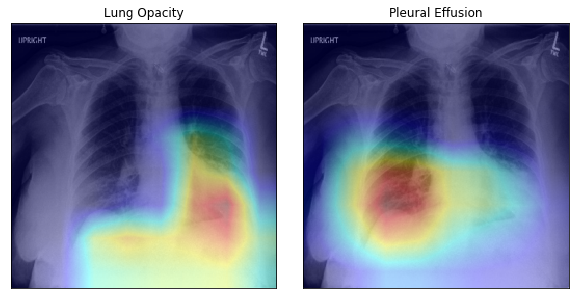

In [70]:
# get image and true labels
imid = 383
print('      ')
print('      ')
print('<<< Image #{} >>>'.format(imid + 1))

path1 = './' + dtest.Path[imid]

print('Path: {}'.format(path1))

image_orig = Image.open(path1).convert('RGB')
image_transformed = transform(image_orig).unsqueeze(0)

true_labels_vec = dtest.iloc[imid,1:].to_numpy().astype(int)
true_labels = np.argwhere(true_labels_vec==1).flatten()
true_labels_uncertain = np.argwhere((-1)*true_labels_vec==1).flatten()

# run model
out = model(image_transformed).cpu()
out_np = out.detach().numpy().squeeze()

pred_labels_binary = findings(out_np)
pred_labels_p = np.round(out_np[pred_labels_binary], 2)

# generate arguments for backward() function corresponding to classes with p>0.5
l = len(pred_labels_binary)
args = []
for ii in pred_labels_binary:
    backward_arg = torch.zeros(1,14)
    backward_arg[0,ii] = 1
    args.append(backward_arg)
    
# generate gradCAMs
hmap_list = []
cam_list = []

img_hmap = np.transpose(image_transformed.squeeze().numpy(),(1,2,0))

# plot
arglen = len(args)
kwargs = dict(xticks=[],yticks=[])

fig, ax = plt.subplots(1, arglen, figsize=(5*arglen,5), subplot_kw=kwargs)
if arglen==1:
    ax = [ax]
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for k, a in enumerate(args):
    print('{}/{}'.format(k+1,arglen))
    out.backward(a, retain_graph=True)

    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    activations = activations.detach()

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    for j in range(gradients.shape[1]):
        activations[:, j, :, :] *= pooled_gradients[j]

    heatmap = torch.sum(activations, dim=1).squeeze().cpu()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)

    hmap_list.append(heatmap)
    
    #ax.flatten()[k].imshow(heatmap)
    

    hmap = heatmap.numpy()
    heatmap1 = cv2.resize(hmap, (img_hmap.shape[1], img_hmap.shape[0]))
    heatmap1 = np.uint8(-255 * heatmap1 + 255)
    heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)

    supim = heatmap1 * 0.002 + img_hmap
    supim = supim / supim.max()
    
    cam_list.append(supim)
    
    ax[k].imshow(supim)
    ax[k].set_title(dtest.columns[1:][pred_labels_binary[k]])

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('True labels:', true_labels, dtest.columns[1:][true_labels].to_list())
print('Uncertainties:', true_labels_uncertain, dtest.columns[1:][true_labels_uncertain].to_list())
print('Prediction:', pred_labels_binary, dtest.columns[1:][pred_labels_binary].to_list())
print('Probabilities:', pred_labels_p)

# Original Image

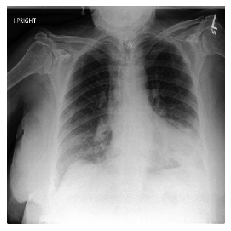

In [71]:
imgOriginal = cv2.imread('./CheXpert-v1.0-small/train/patient00269/study1/view1_frontal.jpg', 1)
imgOriginal = cv2.resize(imgOriginal, (256, 256))
plt.imshow(imgOriginal)
plt.plot()
plt.axis('off')
plt.show()